# Showcasing the Effect of NAMLSS-Robustification using a one-dimensional Example

### NAMLSS Code & Helper Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean() 

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                # print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")
                pass

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [2]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def F2(X):
    return (3 - 3 * X ** 2).squeeze()

def F3(X):
    return (12 * (X - 0.5) ** 2).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

def S2(X):
    return (1.2 - 1/2 * X).squeeze()

def S3(X):
    return (X/X).squeeze()

### Sanity Check: Data with no Outliers

In [3]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

In [4]:
import torch.distributions as dist

########## Drawing Covariate Samples ##########
n_train, n_val, n_test = 10000, 10000, 10000
Uniform = dist.Uniform(0, 1)

X_train = Uniform.sample(sample_shape = [n_train, 1])
X_val = Uniform.sample(sample_shape = [n_val, 1])
X_test = Uniform.sample(sample_shape = [n_test, 1])

########## Training Dataset ##########
F1_train = F1(X_train)
S1_train = S1(X_train)

y_train = F1_train + torch.normal(mean=torch.zeros(n_train), std = S1_train)
y_train = y_train.view(n_train, 1)

########## Validation Dataset ###########
F1_val = F1(X_val)
S1_val = S1(X_val)

y_val = F1_val + torch.normal(torch.zeros(n_val), std = S1_val)
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
F1_test = F1(X_test)
S1_test = S1(X_test)

y_test = F1_test + torch.normal(torch.zeros(n_test), std = S1_test)
y_test = y_test.view(n_test, 1)

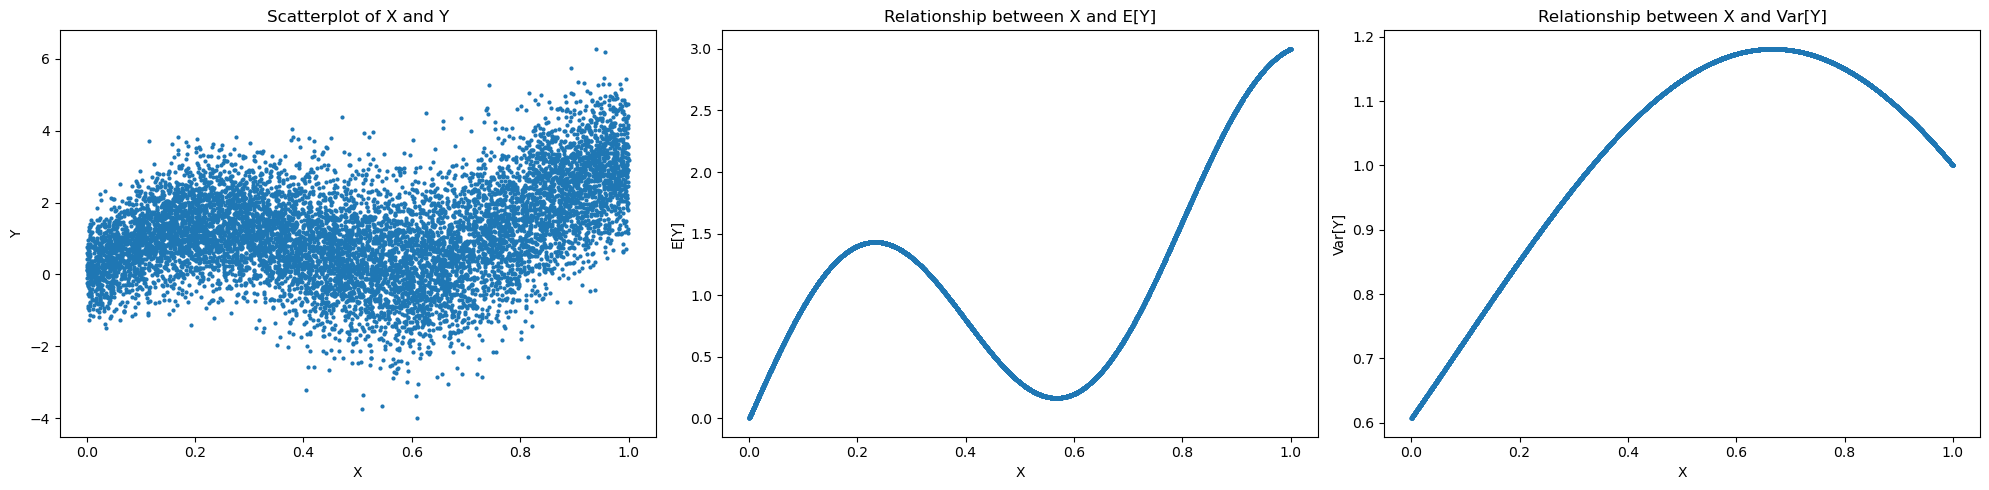

In [5]:
import matplotlib.pyplot as plt

########## Plotting the Data ##########
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axes[0].plot(X_test, y_test, "o", markersize = 2)
axes[0].set_title("Scatterplot of X and Y")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].plot(X_test, F1_test, "o", markersize = 2)
axes[1].set_title("Relationship between X and E[Y]")
axes[1].set_xlabel("X")
axes[1].set_ylabel("E[Y]")

axes[2].plot(X_test, S1_test, "o", markersize = 2)
axes[2].set_title("Relationship between X and Var[Y]")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Var[Y]")

plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [7]:
nam = NormalNAMLSS(1)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

Early stopping at epoch 8130. Best validation loss: 1.1510


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [8]:
robust_nam = NormalNAMLSS(1)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

Early stopping at epoch 7367. Best validation loss: 0.9992


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [9]:
strict_nam = NormalNAMLSS(1)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

Early stopping at epoch 4373. Best validation loss: 0.5965


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [10]:
########## Predicting Parameters on scaled data ##########
mu, sigma = nam.predict(X_test_scaled)
rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling predicted parameters ##########
mu = mu * scaler3.scale_ + scaler3.mean_
rob_mu = rob_mu * scaler3.scale_ + scaler3.mean_
strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

sigma = sigma * scaler3.scale_
rob_sigma = rob_sigma * scaler3.scale_
strict_sigma = strict_sigma * scaler3.scale_

mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

In [11]:
########## Predicted Quantiles ##########
lower = mu - 1.96 * sigma
upper = mu + 1.96 * sigma

robust_lower = rob_mu - 1.96 * rob_sigma
robust_upper = rob_mu + 1.96 * rob_sigma

strict_lower = strict_mu - 1.96 * strict_sigma
strict_upper = strict_mu + 1.96 * strict_sigma

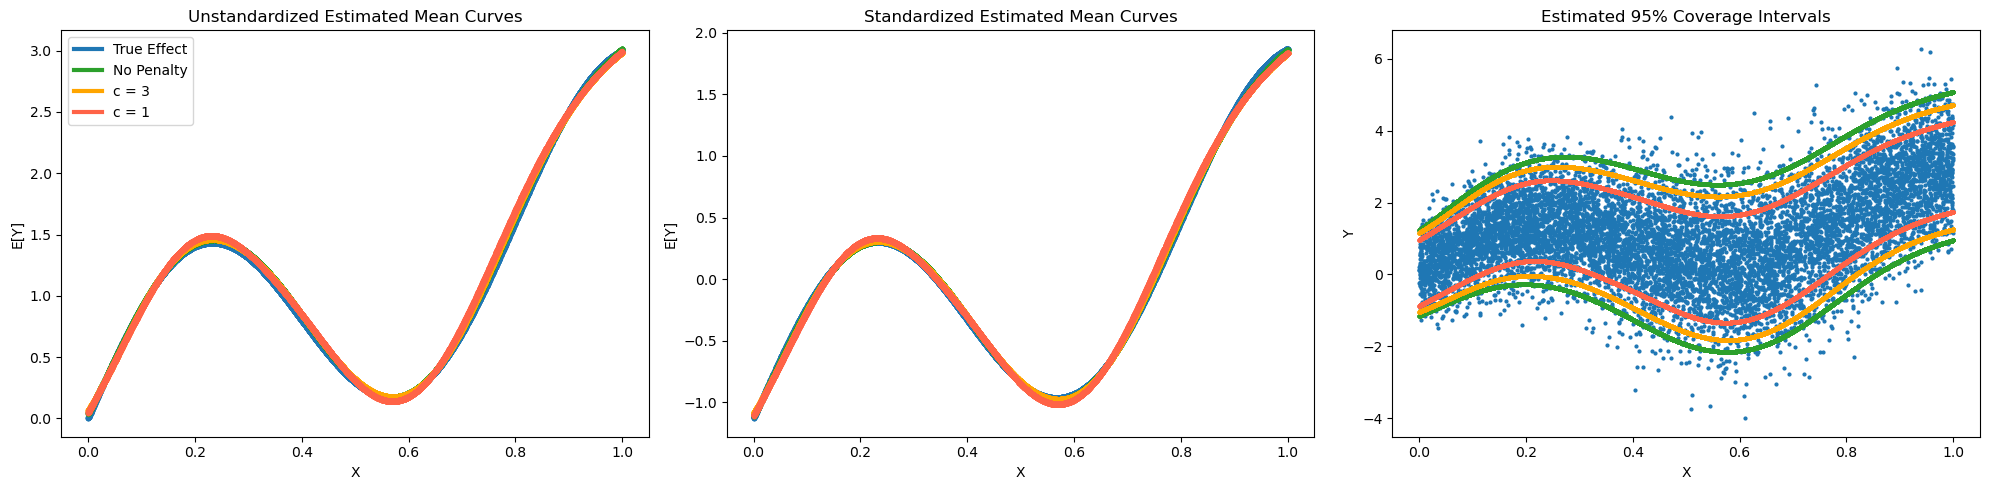

In [12]:
markersize = 3
alpha = 0.4

true_color = "C0"
unregulated_color = "C2"
robust_color = "orange"
strict_color = "tomato"

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

axes[0].plot(X_test, F1_test, "o", color = true_color, markersize = markersize)
axes[0].plot(X_test, mu, "o", color = unregulated_color, markersize = markersize)
axes[0].plot(X_test, rob_mu, "o", color = robust_color, markersize = markersize)
axes[0].plot(X_test, strict_mu, "o", color = strict_color, markersize = markersize)
axes[0].set_title("Unstandardized Estimated Mean Curves")
axes[0].set_xlabel("X")
axes[0].set_ylabel("E[Y]")

axes[1].plot(X_test, F1_test - F1_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test, mu - mu.mean(), "o", color = unregulated_color, markersize = markersize)
axes[1].plot(X_test, rob_mu - rob_mu.mean(), "o", color = robust_color, markersize = markersize)
axes[1].plot(X_test, strict_mu - strict_mu.mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Standardized Estimated Mean Curves")
axes[1].set_xlabel("X")
axes[1].set_ylabel("E[Y]")

axes[2].plot(X_test, y_test, "o", color = true_color, markersize = 2)
axes[2].plot(X_test, lower, "o", color = unregulated_color, markersize = 2)
axes[2].plot(X_test, upper, "o", color = unregulated_color, markersize = 2)
axes[2].plot(X_test, robust_lower, "o", color = robust_color, markersize = 2)
axes[2].plot(X_test, robust_upper, "o", color = robust_color, markersize = 2)
axes[2].plot(X_test, strict_lower, "o", color = strict_color, markersize = 2)
axes[2].plot(X_test, strict_upper, "o", color = strict_color, markersize = 2)
axes[2].set_title("Estimated 95% Coverage Intervals")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")

legend_handles = [
    plt.Line2D([0], [0], color=true_color, linewidth=markersize, label="True Effect"),
    plt.Line2D([0], [0], color=unregulated_color, linewidth=markersize, label="No Penalty"),
    plt.Line2D([0], [0], color=robust_color, linewidth=markersize, label="c = 3"),
    plt.Line2D([0], [0], color=strict_color, linewidth=markersize, label="c = 1"),
]

# for variable in range(3):
#     axes[variable].legend(handles=legend_handles, loc="best")

axes[0].legend(handles = legend_handles, loc = "upper left")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Var[Y]')

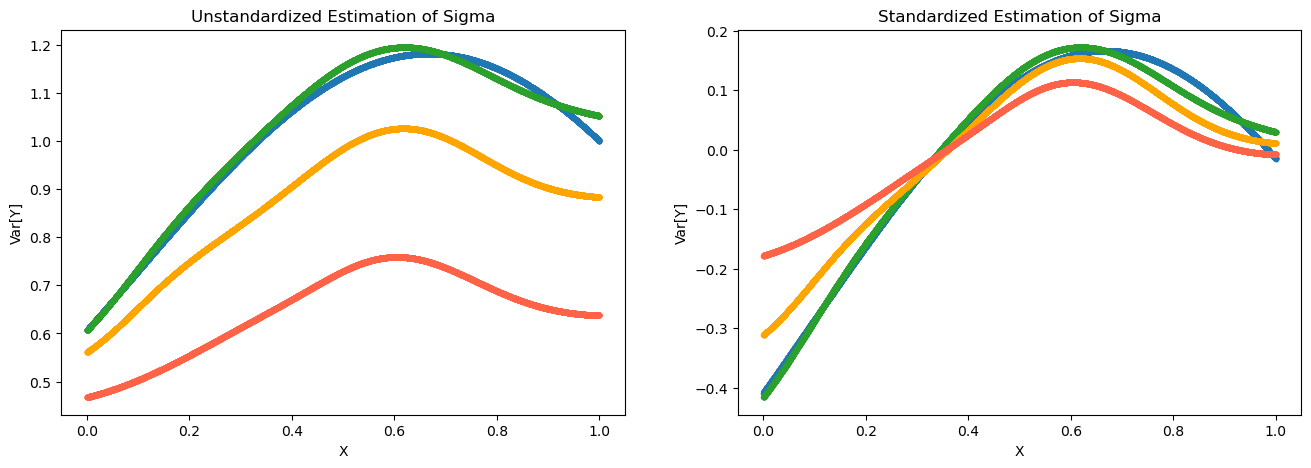

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [16, 5])

axes[0].plot(X_test, S1_test, "o", color = true_color, markersize = markersize)
axes[0].plot(X_test, sigma, "o", color = unregulated_color, markersize = markersize)
axes[0].plot(X_test, robust_sigma_components, "o", color = robust_color, markersize = markersize)
axes[0].plot(X_test, strict_sigma, "o", color = strict_color, markersize = markersize)
axes[0].set_title("Unstandardized Estimation of Sigma")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Var[Y]")

axes[1].plot(X_test, S1_test - S1_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test, sigma - sigma.mean(), "o", color = unregulated_color, markersize = markersize)
axes[1].plot(X_test, rob_sigma - rob_sigma.mean(), "o", color = robust_color, markersize = markersize)
axes[1].plot(X_test, strict_sigma - strict_sigma.mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Standardized Estimation of Sigma")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Var[Y]")

### Onedimensional Scenario with Outliers

In [14]:
import torch.distributions as dist
import matplotlib.pyplot as plt
import random

########## Drawing Covariate Samples ##########
n_train, n_val, n_test = 10000, 10000, 10000
prop_corrupt = 0.2
Uniform = dist.Uniform(0, 1)

X_train = Uniform.sample(sample_shape = [n_train, 1])
X_val = Uniform.sample(sample_shape = [n_val, 1])
X_test = Uniform.sample(sample_shape = [n_test, 1])

########## Training Dataset ##########
F1_train = F1(X_train)
S1_train = S1(X_train)

y_train = F1_train + torch.normal(mean=torch.zeros(n_train), std = S1_train)
y_train = y_train.view(n_train, 1)

corrupted_train_indices = torch.tensor(random.sample(range(1, n_train), int(n_train * prop_corrupt)))
y_train[corrupted_train_indices] = torch.normal(3 - X_train[corrupted_train_indices] + torch.sin(X_train[corrupted_train_indices] * 2.5 * torch.pi), 2)

intact_train_indices = torch.ones(n_train, dtype=bool)
intact_train_indices[corrupted_train_indices] = False

########## Validation Dataset ###########
F1_val = F1(X_val)
S1_val = S1(X_val)

y_val = F1_val + torch.normal(torch.zeros(n_val), std = S1_val)
y_val = y_val.view(n_val, 1)

corrupted_val_indices = torch.tensor(random.sample(range(1, n_val), int(n_val * prop_corrupt)))
y_val[corrupted_val_indices] = torch.normal(3 - X_val[corrupted_val_indices] + torch.sin(X_train[corrupted_val_indices] * 2.5 * torch.pi), 2)

########## Testing Dataset ##########
F1_test = F1(X_test)
S1_test = S1(X_test)

y_test = F1_test + torch.normal(torch.zeros(n_test), std = S1_test)
y_test = y_test.view(n_test, 1)

corrupted_test_indices = torch.tensor(random.sample(range(1, n_test), int(n_test * prop_corrupt)))
y_test[corrupted_test_indices] = torch.normal(3 - X_test[corrupted_test_indices] + torch.sin(X_train[corrupted_test_indices] * 2.5 * torch.pi), 2)

intact_test_indices = torch.ones(n_test, dtype=bool)
intact_test_indices[corrupted_test_indices] = False

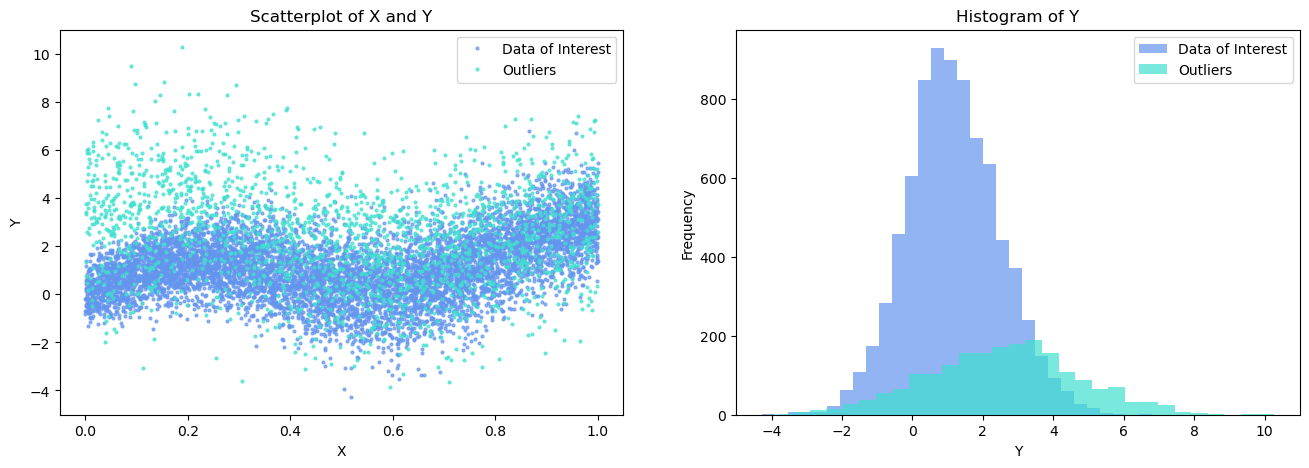

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[16, 5])

# Colors
intact_color = "cornflowerblue"
corrupted_color = "turquoise"

# Scatterplot (Left subplot)
axes[0].plot(X_train[intact_train_indices], y_train[intact_train_indices], "o", color = intact_color, markersize = 2, alpha = 0.7, label = "Data of Interest")
axes[0].plot(X_train[corrupted_train_indices], y_train[corrupted_train_indices], "o", color = corrupted_color, markersize = 2, alpha = 0.7, label = "Outliers")
axes[0].set_title("Scatterplot of X and Y")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

# Histogram (Right subplot)
axes[1].hist(y_train[intact_train_indices].detach().numpy(), bins = 30, color = intact_color, alpha = 0.7, label = "Data of Interest")
axes[1].hist(y_train[corrupted_train_indices].detach().numpy(), bins = 30, color = corrupted_color, alpha = 0.7, label = "Outliers")
axes[1].set_title("Histogram of Y")
axes[1].set_xlabel("Y")
axes[1].set_ylabel("Frequency")

# Legends
axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")

plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [17]:
nam = NormalNAMLSS(1)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

Early stopping at epoch 1066. Best validation loss: 1.3427


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [18]:
robust_nam = NormalNAMLSS(1)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

Early stopping at epoch 6600. Best validation loss: 1.0409


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [19]:
strict_nam = NormalNAMLSS(1)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

Early stopping at epoch 5753. Best validation loss: 0.5918


NormalNAMLSS(
  (submodules): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=8, bias=True)
      (1): Tanh()
      (2): Linear(in_features=8, out_features=2, bias=True)
    )
  )
)

In [20]:
########## Predicting Parameters on scaled data ##########
mu, sigma = nam.predict(X_test_scaled)
robust_mu, robust_sigma = robust_nam.predict(X_test_scaled)
strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling predicted parameters ##########
mu = mu * scaler3.scale_ + scaler3.mean_
robust_mu = robust_mu * scaler3.scale_ + scaler3.mean_
strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

sigma = sigma * scaler3.scale_
robust_sigma = robust_sigma * scaler3.scale_
strict_sigma = strict_sigma * scaler3.scale_

mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

In [21]:
import numpy as np

X_test = X_test.squeeze()

sorted_incides = np.argsort(X_test)
X_test_sorted = X_test[sorted_incides]

mu_sorted = mu[sorted_incides]
robust_mu_sorted = robust_mu[sorted_incides]
strict_mu_sorted = strict_mu[sorted_incides]

sigma_sorted = sigma[sorted_incides]
robust_sigma_sorted = robust_sigma[sorted_incides]
strict_sigma_sorted = strict_sigma[sorted_incides]

In [22]:
########## Predicted Quantiles ##########
lower = mu_sorted - 1.96 * sigma_sorted
upper = mu_sorted + 1.96 * sigma_sorted

robust_lower = robust_mu_sorted - 1.96 * robust_sigma_sorted
robust_upper = robust_mu_sorted + 1.96 * robust_sigma_sorted

strict_lower = strict_mu_sorted - 1.96 * strict_sigma_sorted
strict_upper = strict_mu_sorted + 1.96 * strict_sigma_sorted

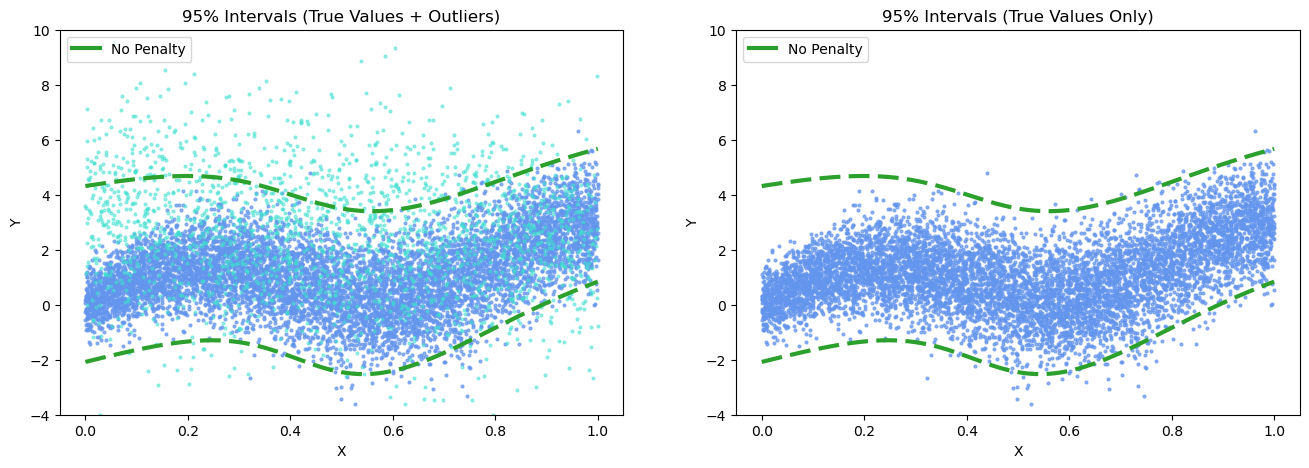

In [23]:
markersize = 3
alpha = 0.4

true_color = "cornflowerblue"
outlier_color = "turquoise"
unregulated_color = "#2ca02c"
robust_color = "indigo"
strict_color = "red"

linewidth = 3
linestyle = (0, (5, 2))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [16, 5])

axes[0].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[0].plot(X_test[corrupted_test_indices], y_test[corrupted_test_indices], "o", color = outlier_color, markersize = 2, alpha = 0.5)
axes[0].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle= linestyle)
axes[0].set_title("95% Intervals (True Values + Outliers)")
axes[0].set_ylim([-4,10])
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[1].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].set_title("95% Intervals (True Values Only)")
axes[1].set_ylim([-4,10])
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")


legend_handles = [
    plt.Line2D([0], [0], color=unregulated_color, linewidth=markersize, label="No Penalty")
]


axes[0].legend(handles = legend_handles, loc = "upper left")
axes[1].legend(handles = legend_handles, loc = "upper left")

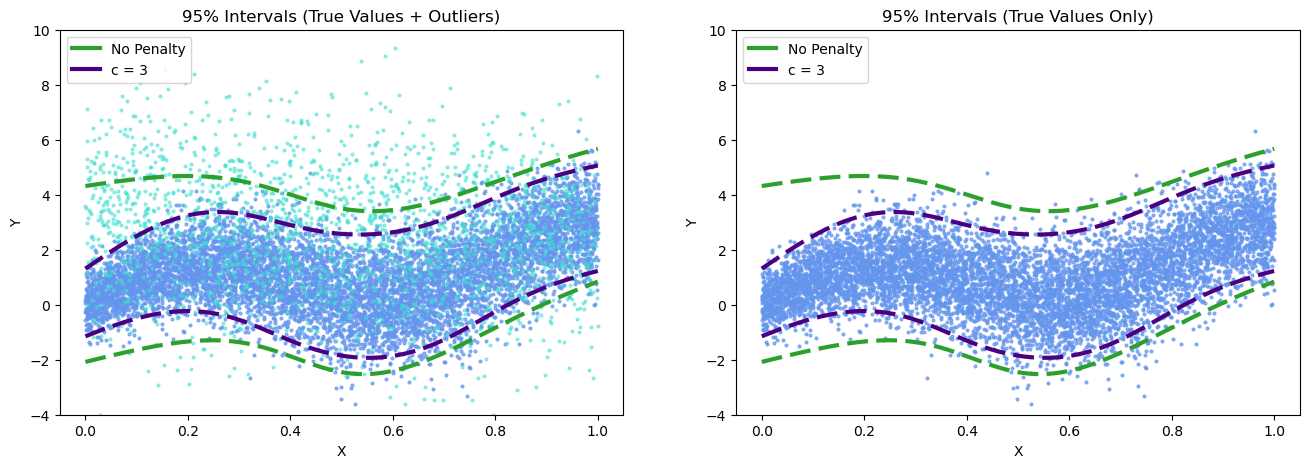

In [24]:
markersize = 3
alpha = 0.4

linewidth = 3
linestyle = (0, (5, 2))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [16, 5])

axes[0].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[0].plot(X_test[corrupted_test_indices], y_test[corrupted_test_indices], "o", color = outlier_color, markersize = 2, alpha = 0.5)
axes[0].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle= linestyle)
axes[0].plot(X_test_sorted, robust_lower, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, robust_upper, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[0].set_title("95% Intervals (True Values + Outliers)")
axes[0].set_ylim([-4,10])
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[1].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, robust_lower, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, robust_upper, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[1].set_title("95% Intervals (True Values Only)")
axes[1].set_ylim([-4,10])
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")


legend_handles = [
    plt.Line2D([0], [0], color=unregulated_color, linewidth=markersize, label="No Penalty"),
    plt.Line2D([0], [0], color=robust_color, linewidth=markersize, label="c = 3"),
]


axes[0].legend(handles = legend_handles, loc = "upper left")
axes[1].legend(handles = legend_handles, loc = "upper left")

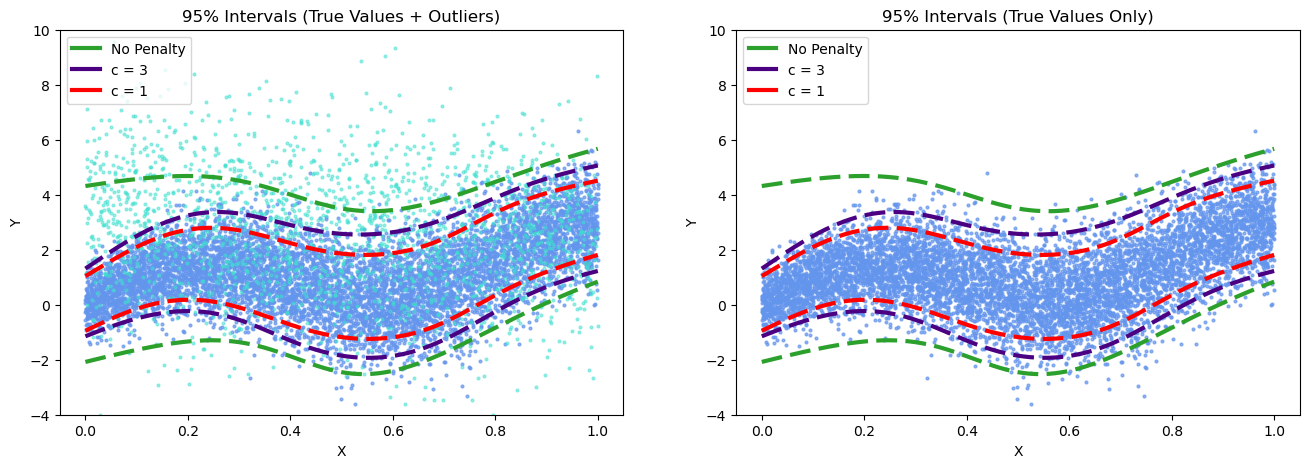

In [25]:
markersize = 3
alpha = 0.4

linewidth = 3
linestyle = (0, (5, 2))

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [16, 5])

axes[0].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[0].plot(X_test[corrupted_test_indices], y_test[corrupted_test_indices], "o", color = outlier_color, markersize = 2, alpha = 0.5)
axes[0].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle= linestyle)
axes[0].plot(X_test_sorted, robust_lower, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, robust_upper, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, strict_lower, color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, strict_upper, color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[0].set_title("95% Intervals (True Values + Outliers)")
axes[0].set_ylim([-4,10])
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].plot(X_test[intact_test_indices], y_test[intact_test_indices], "o", color = true_color, markersize = 2, alpha = 0.7)
axes[1].plot(X_test_sorted, lower, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, upper, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, robust_lower, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, robust_upper, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, strict_lower, color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, strict_upper, color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[1].set_title("95% Intervals (True Values Only)")
axes[1].set_ylim([-4,10])
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")


legend_handles = [
    plt.Line2D([0], [0], color=unregulated_color, linewidth=markersize, label="No Penalty"),
    plt.Line2D([0], [0], color=robust_color, linewidth=markersize, label="c = 3"),
    plt.Line2D([0], [0], color=strict_color, linewidth=markersize, label="c = 1"),
]


axes[0].legend(handles = legend_handles, loc = "upper left")
axes[1].legend(handles = legend_handles, loc = "upper left")

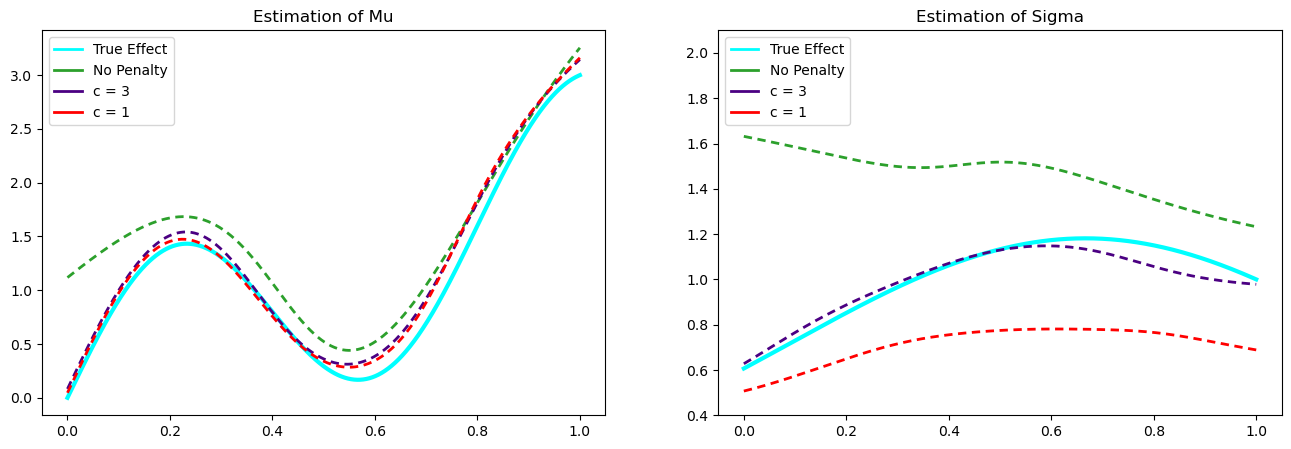

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [16, 5])

linewidth = 2
true_color = "cyan"
linestyle = (0, (3, 2))

axes[0].plot(X_test_sorted, F1_test[sorted_incides], color = true_color, linewidth = linewidth + 1)
axes[0].plot(X_test_sorted, mu_sorted, color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, robust_mu_sorted, color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[0].plot(X_test_sorted, strict_mu_sorted, color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[0].set_title("Estimation of Mu")

axes[1].plot(X_test_sorted, S1_test[sorted_incides], color = true_color, linewidth = linewidth + 1)
axes[1].plot(X_test_sorted, sigma[sorted_incides], color = unregulated_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, robust_sigma[sorted_incides], color = robust_color, linewidth = linewidth, linestyle = linestyle)
axes[1].plot(X_test_sorted, strict_sigma[sorted_incides], color = strict_color, linewidth = linewidth, linestyle = linestyle)
axes[1].set_title("Estimation of Sigma")
axes[1].set_ylim([0.4, 2.1])


legend_handles = [
    plt.Line2D([0], [0], color = true_color, linewidth = linewidth, label = "True Effect"),
    plt.Line2D([0], [0], color = unregulated_color, linewidth=linewidth, label = "No Penalty"),
    plt.Line2D([0], [0], color = robust_color, linewidth=linewidth, label = "c = 3"),
    plt.Line2D([0], [0], color = strict_color, linewidth=linewidth, label = "c = 1"),
]

axes[0].legend(handles = legend_handles, loc = "upper left")
axes[1].legend(handles = legend_handles, loc = "upper left")

In [52]:
import numpy as np
import pandas as pd

# Compute Mean Squared Errors
mse_mu_no_penalty = np.mean((mu_sorted.squeeze() - F1_test[sorted_incides]).numpy()**2) * 100
mse_mu_robust = np.mean((robust_mu_sorted.squeeze() - F1_test[sorted_incides]).numpy()**2) * 100
mse_mu_strict = np.mean((strict_mu_sorted.squeeze() - F1_test[sorted_incides]).numpy()**2) * 100

mse_sigma_no_penalty = np.mean((sigma[sorted_incides].squeeze() - S1_test[sorted_incides]).numpy()**2) * 100
mse_sigma_robust = np.mean((robust_sigma[sorted_incides].squeeze() - S1_test[sorted_incides]).numpy()**2) * 100
mse_sigma_strict = np.mean((strict_sigma[sorted_incides].squeeze() - S1_test[sorted_incides]).numpy()**2) * 100

# Create a DataFrame
mse_table = pd.DataFrame({
    "Method": ["No Penalty", "c = 3", "c = 1"],
    "MSE (Mu)": [mse_mu_no_penalty, mse_mu_robust, mse_mu_strict],
    "MSE (Sigma)": [mse_sigma_no_penalty, mse_sigma_robust, mse_sigma_strict]
})

mse_table


,Method,MSE (Mu),MSE (Sigma)
0,No Penalty,14.135958,26.028675
1,c = 3,1.877137,0.234289
2,c = 1,1.524791,9.996118


In [47]:
F1_test[sorted_incides].shape

torch.Size([10000])

### Multidimensional Scenario - No Outliers

In [ ]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def F2(X):
    return (3 - 3 * X ** 2).squeeze()

def F3(X):
    return (12 * (X - 0.5) ** 2).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

def S2(X):
    return (1.2 - 1/2 * X).squeeze()

def S3(X):
    return (X/X).squeeze()

In [ ]:
import torch.distributions as dist

########## Drawing Covariate Samples ##########
n_train, n_val, n_test = 10000, 10000, 10000
n_var = 3
Uniform = dist.Uniform(0, 1)

X_train = Uniform.sample(sample_shape = [n_train, n_var])
X_val = Uniform.sample(sample_shape = [n_val, n_var])
X_test = Uniform.sample(sample_shape = [n_test, n_var])

########## Training Dataset ##########
F1_train = F1(X_train[:,0])
F2_train = F2(X_train[:,1])
F3_train = F3(X_train[:,2])

S1_train = S1(X_train[:,0])
S2_train = S2(X_train[:,1])
S3_train = S3(X_train[:,2])

y_train = torch.normal(mean = F1_train + F2_train + F3_train, std = S1_train + S2_train + S3_train)
y_train = y_train.view(n_train, 1)

########## Validation Dataset ###########
F1_val = F1(X_val[:,0])
F2_val = F2(X_val[:,1])
F3_val = F3(X_val[:,2])

S1_val = S1(X_val[:,0])
S2_val = S2(X_val[:,1])
S3_val = S3(X_val[:,2])

y_val =  + torch.normal(mean = F1_val + F2_val + F3_val, std = S1_val + S2_val + S3_val)
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
F1_test = F1(X_test[:,0])
F2_test = F2(X_test[:,1])
F3_test = F3(X_test[:,2])

S1_test = S1(X_test[:,0])
S2_test = S2(X_test[:,1])
S3_test = S3(X_test[:,2])

y_test = torch.normal(mean = F1_test + F2_test + F3_test, std = S1_test + S2_test + S3_test)
y_test = y_test.view(n_test, 1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [ ]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

In [ ]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

In [ ]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

In [ ]:
########## Predicting Parameters on scaled data ##########
mu, sigma = nam.predict(X_test_scaled)
rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling predicted parameters ##########
mu = mu * scaler3.scale_ + scaler3.mean_
rob_mu = rob_mu * scaler3.scale_ + scaler3.mean_
strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

sigma = sigma * scaler3.scale_
rob_sigma = rob_sigma * scaler3.scale_
strict_sigma = strict_sigma * scaler3.scale_

mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

In [ ]:
########## Predicted Quantiles ##########
lower = mu - 1.96 * sigma
upper = mu + 1.96 * sigma

robust_lower = rob_mu - 1.96 * rob_sigma
robust_upper = rob_mu + 1.96 * rob_sigma

strict_lower = strict_mu - 1.96 * strict_sigma
strict_upper = strict_mu + 1.96 * strict_sigma

In [ ]:
markersize = 3
alpha = 0.4

true_color = "C0"
unregulated_color = "C2"
robust_color = "orange"
strict_color = "tomato"

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

axes[0].plot(X_test[:,0], F1_test - F1_test.mean(), "o", color = true_color, markersize = markersize)
axes[0].plot(X_test[:,0], mu_components[:,0] - mu_components[:,0].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[0].plot(X_test[:,0], robust_mu_components[:,0] - robust_mu_components[:,0].mean(), "o", color = robust_color, markersize = markersize)
# axes[0].plot(X_test[:,0], strict_mu_components[:,0] - strict_mu_components[:,0].mean(), "o", color = strict_color, markersize = markersize)
axes[0].set_title("Estimated Mean Curves")

axes[1].plot(X_test[:,1], F2_test - F2_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test[:,1], mu_components[:,1] - mu_components[:,1].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[1].plot(X_test[:,1], robust_mu_components[:,1] - robust_mu_components[:,1].mean(), "o", color = robust_color, markersize = markersize)
# axes[1].plot(X_test[:,1], strict_mu_components[:,1] - strict_mu_components[:,1].mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Estimated Mean Curves")

axes[2].plot(X_test[:,2], F3_test - F3_test.mean(), "o", color = true_color, markersize = markersize)
axes[2].plot(X_test[:,2], mu_components[:,2] - mu_components[:,2].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[2].plot(X_test[:,2], robust_mu_components[:,2] - robust_mu_components[:,2].mean(), "o", color = robust_color, markersize = markersize)
# axes[2].plot(X_test[:,2], strict_mu_components[:,2] - strict_mu_components[:,2].mean(), "o", color = strict_color, markersize = markersize)
axes[2].set_title("Estimated Mean Curves")


In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [16, 5])

axes[0].plot(X_test[:,0], S1_test - S1_test.mean(), "o", color = true_color, markersize = markersize)
axes[0].plot(X_test[:,0], sigma_components[:,0] - sigma_components[:,0].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[0].plot(X_test[:,0], robust_sigma_components[:,0] - robust_sigma_components[:,0].mean(), "o", color = robust_color, markersize = markersize)
# axes[0].plot(X_test[:,0], strict_sigma_components[:,0] -strict_sigma_components[:,0].mean(), "o", color = strict_color, markersize = markersize)
axes[0].set_title("Estimated Sigma Curves")

axes[1].plot(X_test[:,1], S2_test - S2_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test[:,1], sigma_components[:,1] - sigma_components[:,1].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[1].plot(X_test[:,1], robust_sigma_components[:,1] - robust_sigma_components[:,1].mean(), "o", color = robust_color, markersize = markersize)
# axes[1].plot(X_test[:,1], strict_sigma_components[:,1] -strict_sigma_components[:,1].mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Estimated Sigma Curves")

axes[2].plot(X_test[:,2], S3_test - S3_test.mean(), "o", color = true_color, markersize = markersize)
axes[2].plot(X_test[:,2], sigma_components[:,2] - sigma_components[:,2].mean(), "o", color = unregulated_color, markersize = markersize)
# axes[2].plot(X_test[:,2], robust_sigma_components[:,2] - robust_sigma_components[:,2].mean(), "o", color = robust_color, markersize = markersize)
# axes[2].plot(X_test[:,2], strict_sigma_components[:,2] -strict_sigma_components[:,2].mean(), "o", color = strict_color, markersize = markersize)
axes[2].set_ylim([-0.3,0.3])
axes[2].set_title("Estimated Sigma Curves")

### Multidimensional Scenario with Outliers

In [ ]:
import torch.distributions as dist
import random

########## Drawing Covariate Samples ##########
n_train, n_val, n_test = 10000, 10000, 10000
prop_corrupt = 0.1
n_var = 3
Uniform = dist.Uniform(0, 1)

X_train = Uniform.sample(sample_shape = [n_train, n_var])
X_val = Uniform.sample(sample_shape = [n_val, n_var])
X_test = Uniform.sample(sample_shape = [n_test, n_var])

########## Training Dataset ##########
F1_train = F1(X_train[:,0])
F2_train = F2(X_train[:,1])
F3_train = F3(X_train[:,2])

S1_train = S1(X_train[:,0])
S2_train = S2(X_train[:,1])
S3_train = S3(X_train[:,2])

y_train = torch.normal(mean = F1_train + F2_train + F3_train, std = S1_train + S2_train + S3_train)
corrupted_train_indices = torch.tensor(random.sample(range(1, n_train), int(n_train * prop_corrupt)))
y_train[corrupted_train_indices] = torch.normal(torch.ones(len(corrupted_train_indices)) * 15, torch.ones(len(corrupted_train_indices)) * 2) # TODO: Bessere Outlier
y_train = y_train.view(n_train, 1)

intact_train_indices = torch.ones(n_train, dtype=bool)
intact_train_indices[corrupted_train_indices] = False

########## Validation Dataset ###########
F1_val = F1(X_val[:,0])
F2_val = F2(X_val[:,1])
F3_val = F3(X_val[:,2])

S1_val = S1(X_val[:,0])
S2_val = S2(X_val[:,1])
S3_val = S3(X_val[:,2])

y_val =  + torch.normal(mean = F1_val + F2_val + F3_val, std = S1_val + S2_val + S3_val)
corrupted_val_indices = torch.tensor(random.sample(range(1, n_val), int(n_val * prop_corrupt)))
y_val[corrupted_val_indices] = torch.normal(torch.ones(len(corrupted_val_indices)) * 15, torch.ones(len(corrupted_val_indices)) * 2) # TODO: Bessere Outlier
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
F1_test = F1(X_test[:,0])
F2_test = F2(X_test[:,1])
F3_test = F3(X_test[:,2])

S1_test = S1(X_test[:,0])
S2_test = S2(X_test[:,1])
S3_test = S3(X_test[:,2])

y_test = torch.normal(mean = F1_test + F2_test + F3_test, std = S1_test + S2_test + S3_test)
corrupted_test_indices = torch.tensor(random.sample(range(1, n_test), int(n_test * prop_corrupt)))
y_test[corrupted_test_indices] = torch.normal(torch.ones(len(corrupted_test_indices)) * 15, torch.ones(len(corrupted_test_indices)) * 2) # TODO: Bessere Outlier

y_test = y_test.view(n_test, 1)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_train[intact_train_indices].numpy(), bins = 30, color = "royalblue", alpha = 0.7)
plt.hist(y_train[corrupted_train_indices].numpy(), bins = 30, color = "tomato", alpha = 0.7)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

In [ ]:
nam = NormalNAMLSS(3)
nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

In [ ]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

In [ ]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

In [ ]:
########## Predicting Parameters on scaled data ##########
mu, sigma = nam.predict(X_test_scaled)
rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

########## Rescaling predicted parameters ##########
mu = mu * scaler3.scale_ + scaler3.mean_
rob_mu = rob_mu * scaler3.scale_ + scaler3.mean_
strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

sigma = sigma * scaler3.scale_
rob_sigma = rob_sigma * scaler3.scale_
strict_sigma = strict_sigma * scaler3.scale_

mu_components = mu_components * scaler3.scale_ + scaler3.mean_
robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

sigma_components = sigma_components * scaler3.scale_
robust_sigma_components = robust_sigma_components * scaler3.scale_
strict_sigma_components = strict_sigma_components * scaler3.scale_

In [ ]:
########## Predicted Quantiles ##########
lower = mu - 1.96 * sigma
upper = mu + 1.96 * sigma

robust_lower = rob_mu - 1.96 * rob_sigma
robust_upper = rob_mu + 1.96 * rob_sigma

strict_lower = strict_mu - 1.96 * strict_sigma
strict_upper = strict_mu + 1.96 * strict_sigma

In [ ]:
markersize = 2
alpha = 0.4

true_color = "C0"
unregulated_color = "C2"
robust_color = "orange"
strict_color = "tomato"

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [16, 5])

axes[0].plot(X_test[:,0], F1_test - F1_test.mean(), "o", color = true_color, markersize = markersize)
axes[0].plot(X_test[:,0], mu_components[:,0] - mu_components[:,0].mean(), "o", color = unregulated_color, markersize = markersize)
axes[0].plot(X_test[:,0], robust_mu_components[:,0] - robust_mu_components[:,0].mean(), "o", color = robust_color, markersize = markersize)
axes[0].plot(X_test[:,0], strict_mu_components[:,0] - strict_mu_components[:,0].mean(), "o", color = strict_color, markersize = markersize)
axes[0].set_title("Estimated Mean Curves")

axes[1].plot(X_test[:,1], F2_test - F2_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test[:,1], mu_components[:,1] - mu_components[:,1].mean(), "o", color = unregulated_color, markersize = markersize)
axes[1].plot(X_test[:,1], robust_mu_components[:,1] - robust_mu_components[:,1].mean(), "o", color = robust_color, markersize = markersize)
axes[1].plot(X_test[:,1], strict_mu_components[:,1] - strict_mu_components[:,1].mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Estimated Mean Curves")

axes[2].plot(X_test[:,2], F3_test - F3_test.mean(), "o", color = true_color, markersize = markersize)
axes[2].plot(X_test[:,2], mu_components[:,2] - mu_components[:,2].mean(), "o", color = unregulated_color, markersize = markersize)
axes[2].plot(X_test[:,2], robust_mu_components[:,2] - robust_mu_components[:,2].mean(), "o", color = robust_color, markersize = markersize)
axes[2].plot(X_test[:,2], strict_mu_components[:,2] - strict_mu_components[:,2].mean(), "o", color = strict_color, markersize = markersize)
axes[2].set_title("Estimated Mean Curves")


In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [16, 5])

axes[0].plot(X_test[:,0], S1_test - S1_test.mean(), "o", color = true_color, markersize = markersize)
axes[0].plot(X_test[:,0], sigma_components[:,0] - sigma_components[:,0].mean(), "o", color = unregulated_color, markersize = markersize)
axes[0].plot(X_test[:,0], robust_sigma_components[:,0] - robust_sigma_components[:,0].mean(), "o", color = robust_color, markersize = markersize)
axes[0].plot(X_test[:,0], strict_sigma_components[:,0] -strict_sigma_components[:,0].mean(), "o", color = strict_color, markersize = markersize)
axes[0].set_title("Estimated Sigma Curves")

axes[1].plot(X_test[:,1], S2_test - S2_test.mean(), "o", color = true_color, markersize = markersize)
axes[1].plot(X_test[:,1], sigma_components[:,1] - sigma_components[:,1].mean(), "o", color = unregulated_color, markersize = markersize)
axes[1].plot(X_test[:,1], robust_sigma_components[:,1] - robust_sigma_components[:,1].mean(), "o", color = robust_color, markersize = markersize)
axes[1].plot(X_test[:,1], strict_sigma_components[:,1] -strict_sigma_components[:,1].mean(), "o", color = strict_color, markersize = markersize)
axes[1].set_title("Estimated Sigma Curves")

axes[2].plot(X_test[:,2], S3_test - S3_test.mean(), "o", color = true_color, markersize = markersize)
axes[2].plot(X_test[:,2], sigma_components[:,2] - sigma_components[:,2].mean(), "o", color = unregulated_color, markersize = markersize)
axes[2].plot(X_test[:,2], robust_sigma_components[:,2] - robust_sigma_components[:,2].mean(), "o", color = robust_color, markersize = markersize)
axes[2].plot(X_test[:,2], strict_sigma_components[:,2] -strict_sigma_components[:,2].mean(), "o", color = strict_color, markersize = markersize)
axes[2].set_ylim([-1, 1])
axes[2].set_title("Estimated Sigma Curves")